# [Tensorflow - Help Protect the Great Barrier Reef](https://www.kaggle.com/c/tensorflow-great-barrier-reef)
> 水中の画像データからオニヒトデを検出する

## 📒 Notebooks:
copy&edit
* Train: [Great-Barrier-Reef: YOLOv5 [train] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)
* Infer: [Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

# 🛠 必要なライブラリのインストール
* imagesize: 画像のサイズを測定できる
* wandb: 実験管理ができるライブラリ
    * [参考サイト](https://www.nogawanogawa.com/entry/wandb)
    * [公式チュートリアル](https://docs.wandb.ai/)
* libstdc++6: おそらくopencvのために必要なもの

In [1]:
!pip install -q imagesize
!pip install -qU wandb
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt-get update
!apt-get upgrade libstdc++6 -y

/bin/sh: 1: add-apt-repository: not found
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:4 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2461 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2898 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1450 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2228 kB]
Fetched 9290 kB in 4s (2576 kB/s)  
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libstdc++6 is already the newest version (8.4.0-1ubuntu1~18.04).
Calculating upgrade... Done
The following packages will be upgraded:
  libglib2.0-0 libglib

# 📚 Import Libraries

In [1]:
from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
import glob

import torch
from PIL import Image

import shutil

import sys
sys.path.append('/workspace/cots/data')
# sys.path.append('../input/tensorflow-great-barrier-reef')

from joblib import Parallel, delayed
import imagesize

# 📌 キーポイント
* これまでの物体検出コンペと違って**python time-series API**を使って予測が行われる
* BBoxの提出フォーマットはCOCO形式 `[x_min, y_min, width, height]`
* 今回の評価指標は`F2`なので、Recall重視の方が評価指標が上がりやすい。つまり、オニヒトデの誤検出より、見逃し減らすようにした方がスコアが上がりやすい
$$F2 = 5 \cdot \frac{precision \cdot recall}{4\cdot precision + recall}$$

# ⭐ WandB
Weights & Biases (W&B) は、MLOpsの実験をトラッキングするためのプラットフォーム。実験のトラッキング、データセットのバージョニング、モデルの管理ができる。

W&Bの良い機能を一部紹介(copy元の著者由来)

* 実験の追跡、比較、可視化
* ライブメトリクス(live metrics)、ターミナルログ、システム統計情報(system stats)をダッシュボードで見れる
* モデルのバージョンがどのように改善されたかをグラフで示せる

# 📖 Meta Data
* `train_images/` - `video_{video_id}/{video_frame}.jpg`という形での学習画像が含まれるフォルダ

* `[train/test].csv` - 画像のメタ情報。テストのメタデータはsubmitしたときにダウンロードされる。submit前は3つの画像に関する情報しかない
* `video_id` - 画像の含まれるvideoのID番号。video_idの順序に特に意味はない。
* `video_frame` - video中に含まれる画像のフレーム番号。同じvideo_idでもダイバーの潜水、浮上があったりするため、急に視点が変わったりする。
* `sequence` - 先ほどのダイバーの潜水、浮上ごとにvideoを細かく分けた時のid。順序に大きな意味はない(著者はこう言ってるが...本当に意味がないのか?)
* `sequence_frame` - sequence中の画像のフレーム番号。
* `image_id` - `{video_id}-{video_frame}`
* `annotations` - オニヒトデのbbox情報。提出する際のフォーマットではないことに注意。`test.csv`では利用できない。このbbox情報の形式はbboxの左下の座標`(x_min, y_min)`と、そこからの`width`と`height`で記載されていて、これはCOCO formatと呼ばれるらしい。


In [2]:
# FOLD      = 4 # which fold to train 0 ~ 4
REMOVE_NOBBOX = True # remove images with no bbox
DATA_DIR  = '/workspace/cots/data'
IMAGE_DIR = f'{DATA_DIR}/images' # directory to save images
LABEL_DIR = f'{DATA_DIR}/labels' # directory to save labels

## Create Directories

In [3]:
# -p : 必要に応じて親ディレクトリも作成
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Paths

In [4]:
def get_path(row):
    """
    画像のpathを格納する
    """
    row['old_image_path'] = f'{DATA_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    row['image_path'] = f'{IMAGE_DIR}/video_{row.video_id}_{row.video_frame}.jpg'
    row['label_path'] = f'{LABEL_DIR}/video_{row.video_id}_{row.video_frame}.txt'
    return row

In [5]:
# Train Data

# df = df.progress_apply(get_path, axis=1)
# df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))

df = pd.read_csv(f'{DATA_DIR}/train.csv')
df = df.apply(get_path, axis=1)
# 文字列をリストに変換
df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x))
display(df.head(2))

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                    old_image_path  \
0  /workspace/cots/data/train_images/video_0/0.jpg   
1  /workspace/cots/data/train_images/video_0/1.jpg   

                                  image_path  \
0  /workspace/cots/data/images/video_0_0.jpg   
1  /workspace/cots/data/images/video_0_1.jpg   

                                  label_path  
0  /workspace/cots/data/labels/video_0_0.txt  
1  /workspace/cots/data/labels/video_0_1.txt

## Number of BBoxes
> trainの大体80%はオニヒトデが写ってない

In [6]:
# df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
df['num_bbox'] = df['annotations'].apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

No BBox: 79.07% | With BBox: 20.93%


# 🧹 Clean Data (オニヒトデが写ってるデータのみに)

* 学習データはオニヒトデが写ってるデータのみに制限する(copy元の著者は簡単に実験できるからこうしているとのこと)
    * オニヒトデが写っていないデータを学習にうまいこと使う　or　アノテーション漏れしてるデータを追加するのは有効かも

In [7]:
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

# ✏️ Write Images (学習するための画像を抽出)

* kaggle　notebook上で行うときには、kaggle notebookのデフォルトのcurrent directory(`/kaggle/working`)に(`/kaggle/input`)からコピーしないと、書き込み権限が`/kaggle/input`にないため、yolov5を動かした時にエラーになる
* この処理は**Joblib**の**Parallel**で高速化できる

In [8]:
def make_copy(path):
    data = path.split('/')
    filename = data[-1]
    video_id = data[-2]
    new_path = os.path.join(IMAGE_DIR,f'{video_id}_{filename}')
    shutil.copy(path, new_path)
    return

In [9]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(path) for path in tqdm(image_paths))

# 🔨 Helper

主に
* bboxのアノテーションの形式(coco->yolo, voc->yolo など)を変える関数
* 画像を描画するための関数
が定義されてる

In [10]:
def voc2yolo(image_height, image_width, bboxes):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """

    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(image_height, image_width, bboxes):
    """
    cocoフォーマットから、yoloフォーマット
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yoloフォーマットからcocoフォーマット
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes


def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(image_height, image_width, bboxes)
    bboxes  = yolo2coco(image_height, image_width, bboxes)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    """
    画像自体のサイズの獲得
    """
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row


def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))


np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox (数値だけの形に)

In [11]:
# df['bboxes'] = df.annotations.progress_apply(get_bbox)
df['bboxes'] = df.annotations.apply(get_bbox)
df.head(2)

video_id  sequence  video_frame  sequence_frame image_id  \
16         0     40258           16              16     0-16   
17         0     40258           17              17     0-17   

                                          annotations  \
16  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]   
17  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]   

                                      old_image_path  \
16  /workspace/cots/data/train_images/video_0/16.jpg   
17  /workspace/cots/data/train_images/video_0/17.jpg   

                                    image_path  \
16  /workspace/cots/data/images/video_0_16.jpg   
17  /workspace/cots/data/images/video_0_17.jpg   

                                    label_path  num_bbox                bboxes  
16  /workspace/cots/data/labels/video_0_16.txt         1  [[559, 213, 50, 32]]  
17  /workspace/cots/data/labels/video_0_17.txt         1  [[558, 213, 50, 32]]

## Get Image-Size (画像(jpg)のサイズは均等かどうか)
> 全部の画像のサイズが(横, 縦) = (1280, 720)になってる

In [12]:
# df = df.progress_apply(get_imgsize,axis=1)
df = df.apply(get_imgsize,axis=1)
display(df.width.unique(), df.height.unique())
display(df.head(2))

array([1280])

array([720])

video_id  sequence  video_frame  sequence_frame image_id  \
16         0     40258           16              16     0-16   
17         0     40258           17              17     0-17   

                                          annotations  \
16  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]   
17  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]   

                                      old_image_path  \
16  /workspace/cots/data/train_images/video_0/16.jpg   
17  /workspace/cots/data/train_images/video_0/17.jpg   

                                    image_path  \
16  /workspace/cots/data/images/video_0_16.jpg   
17  /workspace/cots/data/images/video_0_17.jpg   

                                    label_path  num_bbox  \
16  /workspace/cots/data/labels/video_0_16.txt         1   
17  /workspace/cots/data/labels/video_0_17.txt         1   

                  bboxes  width  height  
16  [[559, 213, 50, 32]]   1280     720  
17  [[558, 213, 50, 32]]   1280     720

# 🏷️ Create Labels (YOLOのフォーマットのBBox作成)
コンペのbboxフォーマットはCOCOのものなのでYOLOのformatに変える必要がある 

yolov5の入力のために各画像ごとのbboxの情報を記載する`*.txt`が必要。`*.txt`の細かい指定は下記参照。

* オブジェクトごとに1行 (1枚の画像にオニヒトデが2つあるなら２行になる)
* 各行は`class_no, x_center, y_center, width, height`という形式 (bboxはyolo形式ということ)
* bboxは0~1で正規化されていないといけない。つまり、`x_center`と`width`は画像の横(`image_width`)で、`y_center`と`height`は画像の縦(`image_height`)で除算する。
* クラスは0始まり (そもそも今回はオニヒトデだけなので0だけだが)

> コンペのbboxの形式はCOCO形式(`[x_min, y_min, width, height]`)なので、yolo形式(`[x_center, y_center, width, height]`)に変換する必要がある

In [13]:
cnt = 0
all_bboxes = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = [0]*num_bbox
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
            annot = ' '.join(annot)
            annot = annot.strip(' ')
            f.write(annot)
print('Missing:',cnt)


Missing: 0


# 📁 Create Folds
**現在未使用**
> 各フォールドのサンプル数が同じではないため、クロスバリデーションにおいて大きなばらつきが生じるとのこと

In [18]:
# from sklearn.model_selection import GroupKFold
# kf = GroupKFold(n_splits = 5)
# df = df.reset_index(drop=True)
# df['fold'] = -1
# for fold, (train_idx, val_idx) in enumerate(kf.split(df, y = df.video_id.tolist(), groups=df.sequence)):
#     df.loc[val_idx, 'fold'] = fold
# display(df.fold.value_counts().sort_index())

## 📁 video_idで分割

video_idごとの(ヒトデが写っている)画像の枚数

In [19]:
df.groupby('video_id').sequence.count()

video_id
0    2143
1    2099
2     677
Name: sequence, dtype: int64

# 🍚 Dataset

In [20]:
train_files = []
val_files   = []
train_df = df.query("video_id!=2")
valid_df = df.query("video_id==2")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

(4242, 677)

In [21]:
# trainとvalidの割合
print("train: ", round(len(train_files)/ (len(train_files) + len(val_files)) * 100, 1), '%')
print("valid: ", round(len(val_files)/ (len(train_files) + len(val_files)) * 100, 1), '%')

train:  86.2 %
valid:  13.8 %


# ⚙️ Configuration

datasetのconfig fileが必要
1. datasetのroot　dierectory pathと`train / val / test`の画像ファイルのディレクトリ(もしくは、画像のpathが記載された*.txtファイル)を記載する
2. クラスの数を`nc`として記載する
3. クラスのリストを `names` : `['cots']`という形で記載する 

この辺りは実際にyamlの中身を見た方が早い

In [22]:
import yaml

cwd = '/workspace/cots/data/'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = '/workspace/cots/data/',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['cots'],
    )

with open(os.path.join( cwd , 'tgbr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'tgbr.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- cots
nc: 1
path: /workspace/cots/data/
train: /workspace/cots/data/train.txt
val: /workspace/cots/data/val.txt



# 📦 [YOLOv5](https://github.com/ultralytics/yolov5/)

この辺りのディレクトリの配置はよしなに設定する

In [23]:
# %cd data/
# !rm -r data/yolov5
# !git clone https://github.com/ultralytics/yolov5 # clone

In [24]:
# !cp -r /kaggle/input/yolov5-lib-ds /kaggle/working/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

/workspace/cots/yolov5
Note: you may need to restart the kernel to use updated packages.


In [25]:
from yolov5 import utils

In [26]:
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-128-g581dc30 torch 1.8.1 CUDA:3 (Tesla V100-PCIE-32GB, 32510MiB)


Setup complete ✅


In [27]:
# Weights & Biases  (optional)
import wandb
wandb.login(anonymous='must')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anony-mouse-171174 (use `wandb login --relogin` to force relogin)


True

# 🚅 Training

In [29]:
# Train YOLOv5s on COCO128 for 3 epochs ← 事前学習の情報?
# --batch 16\ --epochs 30\
# --cache\
# --evolve\ ← ハイパラチューニングしてくれる
# --hyp /workspace/cots/yolov5/data/hyps/hyp.finetune.yaml\ ← ハイパラの設定
# --hyp /workspace/cots/yolov5/data/hyps/hyp.scratch-high.yaml\

!python train.py --img 1280\
--device 3\
--batch 16\
--epochs 30\
--data /workspace/cots/data/tgbr.yaml\
--hyp /workspace/cots/yolov5/data/hyps/hyp_evolve.yaml\
--weights yolov5s6.pt

wandb: Currently logged in as: anony-mouse-171174 (use `wandb login --relogin` to force relogin)
train: weights=yolov5s6.pt, cfg=, data=/workspace/cots/data/tgbr.yaml, hyp=/workspace/cots/yolov5/data/hyps/hyp_evolve.yaml, epochs=30, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=3, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.0-128-g581dc30 torch 1.8.1 CUDA:3 (Tesla V100-PCIE-32GB, 32510MiB)

hyperparameters: lr0=0.0104, lrf=0.10001, momentum=0.92695, weight_decay=0.0005, warmup_epochs=2.9328, warmup_momentum=0.93826, 

# ✨ Overview

## Output Files

In [31]:
exp_no =7

In [32]:
!ls /workspace/cots/yolov5/runs/train/exp{exp_no}

F1_curve.png					     results.png
PR_curve.png					     train_batch0.jpg
P_curve.png					     train_batch1.jpg
R_curve.png					     train_batch2.jpg
confusion_matrix.png				     val_batch0_labels.jpg
events.out.tfevents.1639445267.e902a6879b51.81175.0  val_batch0_pred.jpg
hyp.yaml					     val_batch1_labels.jpg
labels.jpg					     val_batch1_pred.jpg
labels_correlogram.jpg				     val_batch2_labels.jpg
opt.yaml					     val_batch2_pred.jpg
results.csv					     weights


# 🔭 Batch Image

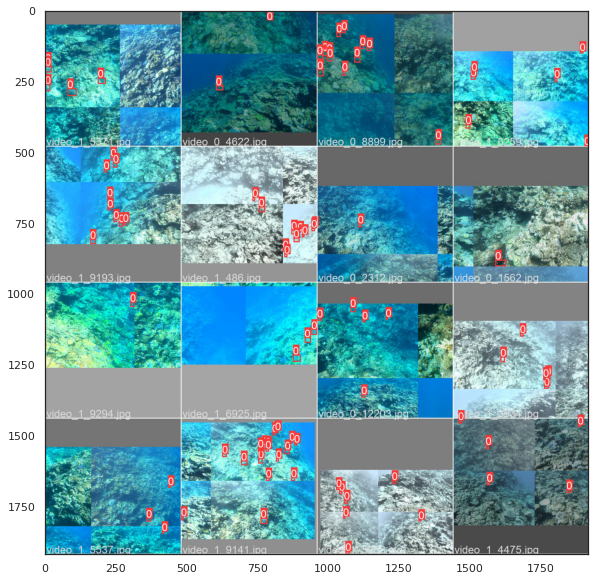

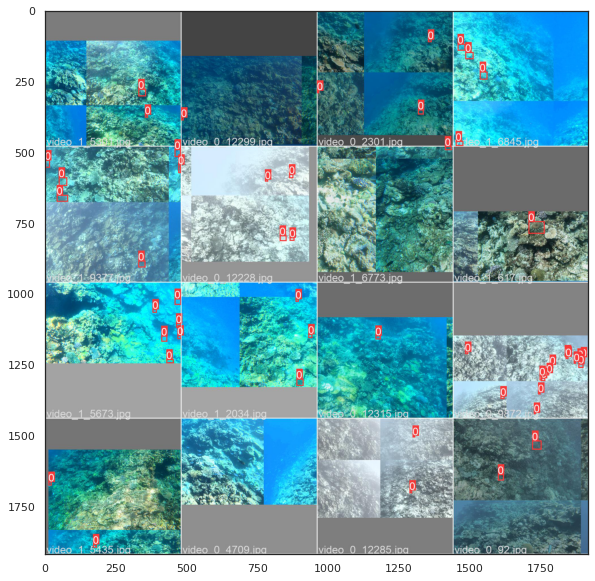

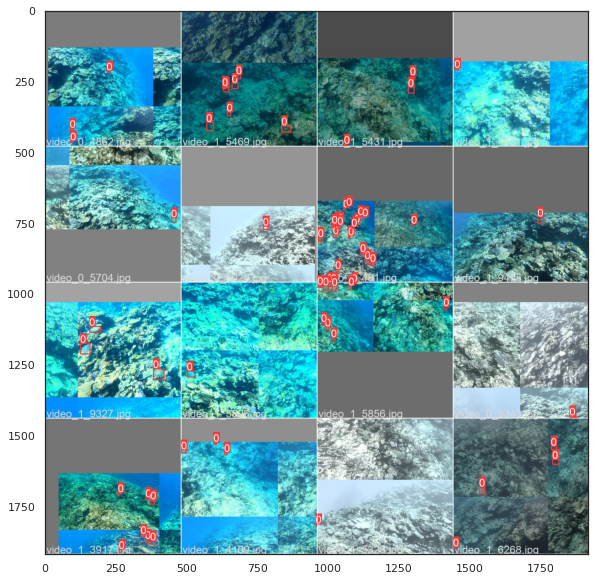

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/train_batch2.jpg'))

## GT Vs Pred

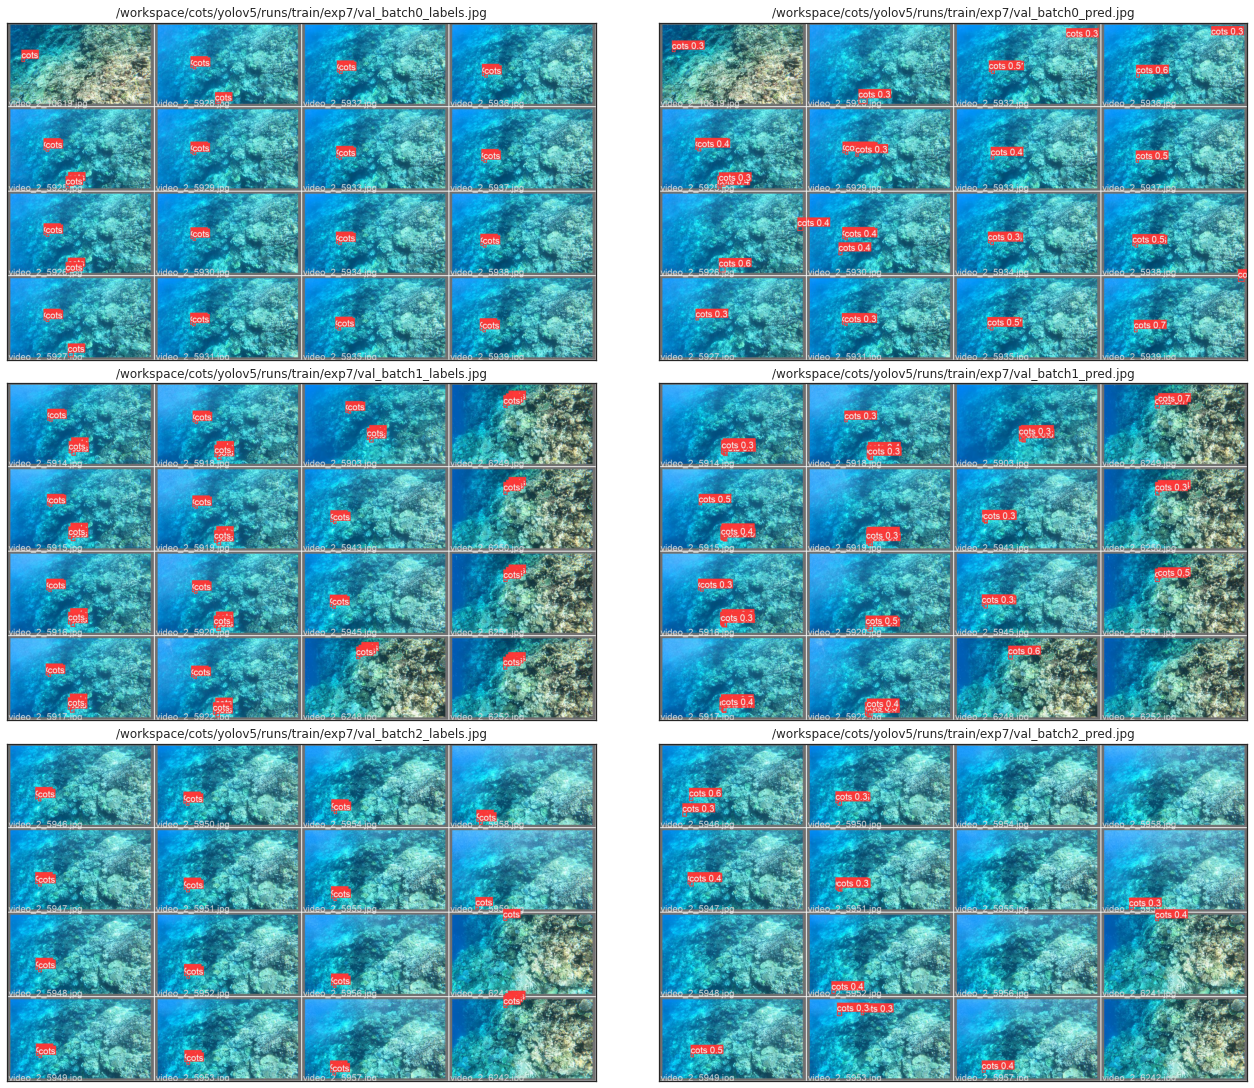

In [36]:
fig, ax = plt.subplots(3, 2, figsize = (2*9,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

# 🔍 Result

## Metrics

Metric: F1


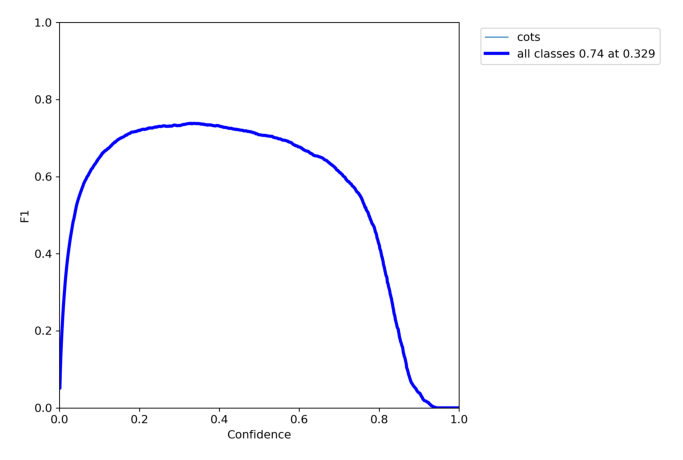

Metric: PR


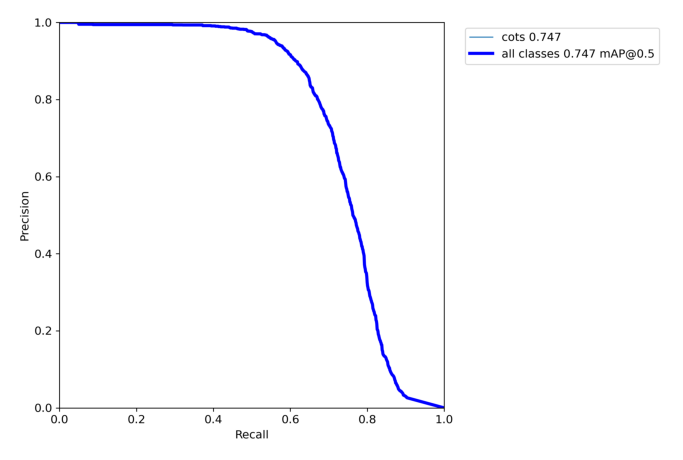

Metric: P


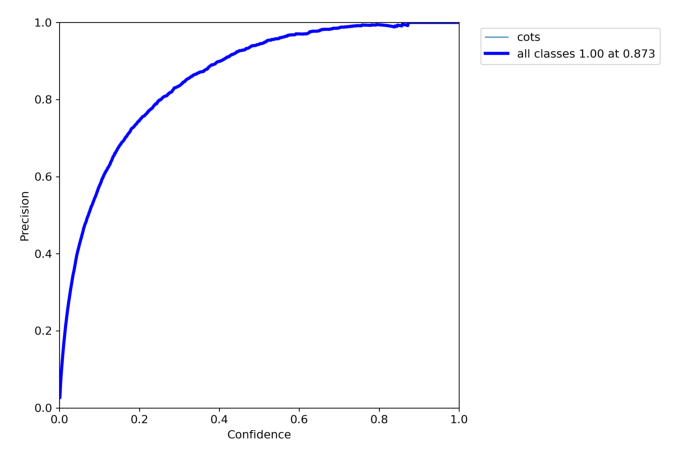

Metric: R


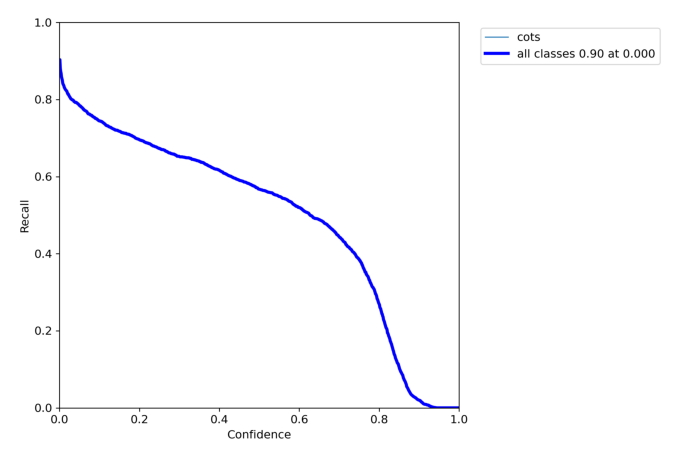

In [39]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'/workspace/cots/yolov5/runs/train/exp{exp_no}/{metric}_curve.png'));
    plt.show()

# Calculation Val CV

In [40]:
CKPT_PATH = f'/workspace/cots/yolov5/runs/train/exp{exp_no}/weights/best.pt'
IMG_SIZE  = 1280
# CONF      = 0.15
# IOU       = 0.50
CONF      = 0.4
IOU       = 0.2
AUGMENT   = False
DEVICE = 3

## helper

In [41]:
def load_model(ckpt_path, conf=0.25, iou=0.50, device=0):
    model = torch.hub.load('/workspace/cots/yolov5',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True,
                           device=device)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model


def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        # bboxes  = voc2coco(bboxes, height, width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]

In [42]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU, device=3)

YOLOv5 🚀 v6.0-128-g581dc30 torch 1.8.1 CUDA:3 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 


In [43]:
image_paths = valid_df.image_path.tolist()
preds_bboxes = []
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)[...,::-1]
    height, width = img.shape[:2]
    bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    if len(bboxes):
        preds_bboxes.append(torch.sort(torch.from_numpy(bboxes.astype(np.float32)), dim=0).values)
        bboxes = voc2coco(bboxes, height, width)
    else:
        preds_bboxes.append(bboxes)
    # if idx<3:
    #     display(show_img(img, bboxes, bbox_format='coco'))

In [44]:
from typing import List

from torchvision.ops import box_iou


def calculate_score(
    preds: List[torch.Tensor],
    gts: List[torch.Tensor],
    iou_th: float
) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    return score

In [45]:
gt = valid_df.bboxes.apply(lambda x: torch.sort(
                                        torch.tensor(
                                            yolo2voc(720, 1280,
                                                     coco2yolo(720, 1280, 
                                                               np.array(x).astype(np.float32)
                                                )
                                            )
                                        ), dim=0).values).values.tolist()

In [ ]:
iou_ths = np.arange(0.3, 0.85, 0.05)
scores = [calculate_score(preds_bboxes, gt, iou_th) for iou_th in iou_ths]
np.mean(scores)

0.3717596463982798

# ✂️ Remove Files
copy元のnotebookの著者は容量を気にしているのか実行するたびに作った画像ファイルを消してる


ここはやらなくてもやってもいいと思う

In [32]:
!rm -r {IMAGE_DIR}
!rm -r {LABEL_DIR}